In [5]:
import os

import torch
import numpy as np

from model import model_cINN_without_distr as model_cINN
from model.modules import data_preprocessing
from model.modules import dataset_supercell as dataset
from model.modules import loader
from model.modules import utils
from model.modules import visualizations
from model.modules import dist_utils

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
from matplotlib import cm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['lines.linewidth']=6
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [6]:
supercells = ['/bigdata/hplsim/aipp/Anna/lwfa_tests/'+nextfile for nextfile in os.listdir('/bigdata/hplsim/aipp/Anna/lwfa_tests')]
datasets = []
models = []

for ind in range(len(supercells)):
    datasets.append(dataset.PCDataset(item_phase_space=supercells[ind],
                                   normalize=True, a=0., b=1.))
    models.append(model_cINN.PC_NF(dim_condition=2,
                               dim_input=6,
                               num_coupling_layers=3,
                               hidden_size=64,
                               device='cpu',
                               enable_wandb=False))

PS Minima: 
	 tensor([ 3.4402e+02,  9.2000e+03,  2.0401e+02,  6.6269e-03, -8.4478e-02,
         3.2710e-02])
PS Maxima: 
	 tensor([ 3.5199e+02,  9.2080e+03,  2.0794e+02,  3.5258e-02, -2.5832e-02,
         5.8264e-02])
PS Minima: 
	 tensor([ 3.5201e+02,  9.2080e+03,  2.0401e+02, -3.2538e-02, -8.7331e-02,
         2.5369e-02])
PS Maxima: 
	 tensor([ 3.5998e+02,  9.2160e+03,  2.0800e+02,  2.0174e-02, -5.9843e-03,
         7.3354e-02])
PS Minima: 
	 tensor([ 3.4404e+02,  9.2080e+03,  2.0402e+02, -6.1191e-05, -1.1137e-01,
         2.9716e-02])
PS Maxima: 
	 tensor([ 3.5197e+02,  9.2160e+03,  2.0800e+02,  2.7826e-02, -5.7569e-02,
         5.9706e-02])
PS Minima: 
	 tensor([ 3.5201e+02,  9.2000e+03,  2.0000e+02, -3.5212e-02, -5.0665e-02,
         1.8530e-02])
PS Maxima: 
	 tensor([3.5999e+02, 9.2080e+03, 2.0400e+02, 1.4724e-02, 9.5873e-03, 7.0602e-02])
PS Minima: 
	 tensor([ 3.4401e+02,  9.2000e+03,  2.0005e+02,  3.3914e-03, -8.3073e-02,
         2.4416e-02])
PS Maxima: 
	 tensor([ 3.5199e+02

In [7]:
optimizers = []
test_pointclouds = []
for ind in range(len(supercells)):
    optimizers.append(torch.optim.Adam(models[ind].model.parameters(), lr=1e-3,
                             betas=(0.8, 0.9), eps=1e-6, weight_decay=2e-5))
    test_pointclouds.append(supercells[ind])
    
test_radiation = "/home/willma32/insitu_particles/InSituML/main/ModelHelpers/cINN/rad_test.npy"
log_plots = visualizations.log_one_plot

In [8]:
import time
for ind in range(len(supercells)):
    print('Train: ', supercells[ind].split('/')[-1].split('.')[0])
    models[ind].device = 'cuda'
    models[ind].to('cuda')
    #models[ind].model = dist_utils.maybe_ddp_wrap(models[ind].model)
    s = time.time()
    models[ind].train_(datasets[ind],
                   datasets[ind],
                   optimizers[ind],
                   epochs=1001,
                   batch_size=10000,
                   test_epoch=1000,
                   test_pointcloud=test_pointclouds[ind], test_radiation=test_radiation, log_plots=None,
                   path_to_models='/bigdata/hplsim/aipp/Anna/lwfa_tests1/models/RESModels_'+supercells[ind].split('/')[-1].split('.')[0]+'/')
    e = time.time()
    print('time on cuda, cINN training: ', e-s, 's')
    break

Train:  10700_43_1150_51
Total number of points:  438
Size of loader:  1
epoch : 1/1001,
	loss_avg = -0.098339185118675,
	loss_z = 0.183189108967781,
	loss_j = 0.281528294086456
epoch : 1001/1001,
	loss_avg = -7.044547557830811,
	loss_z = 1.409811377525330,
	loss_j = 8.454359054565430
time on cuda, cINN training:  67.72025990486145 s


In [31]:
param_size = 0
for param in models[0].model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in models[0].model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.113MB


In [20]:
supercells_tensors = []
for ind in range(len(supercells)):
    supercells_tensors.append(np.loadtxt(supercells[ind]))
all_cells = np.concatenate([arr for arr in supercells_tensors], axis=0)
print(all_cells.shape)

(4060, 6)


In [21]:
#supercell = [int(k) for k in test_pointcloud.split('/')[-1].split('.')[0].split('_')[1:]]
iteration = '10700'
pointcloud_tensor = all_cells

num_particles = 500
idx = np.random.randint(pointcloud_tensor.shape[0], size=num_particles)
pointcloud_tensor = pointcloud_tensor[idx, :]
radiation_tensor = torch.Tensor([0.5,0.5]).float().repeat(pointcloud_tensor.shape[0], 1)

labels_x = ['x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp']

pred_pointclouds = []
for ind in range(len(supercells)):
    pred_pointclouds.append((models[ind].sample_pointcloud(radiation_tensor.to(models[ind].device), radiation_tensor.shape[0])).detach().cpu().numpy())
    
pred_pointcloud = np.concatenate([arr for arr in pred_pointclouds], axis=0)
print(pred_pointcloud.shape)
#pred_pointcloud = pred_pointcloud_full.detach().cpu().numpy()

(4000, 6)


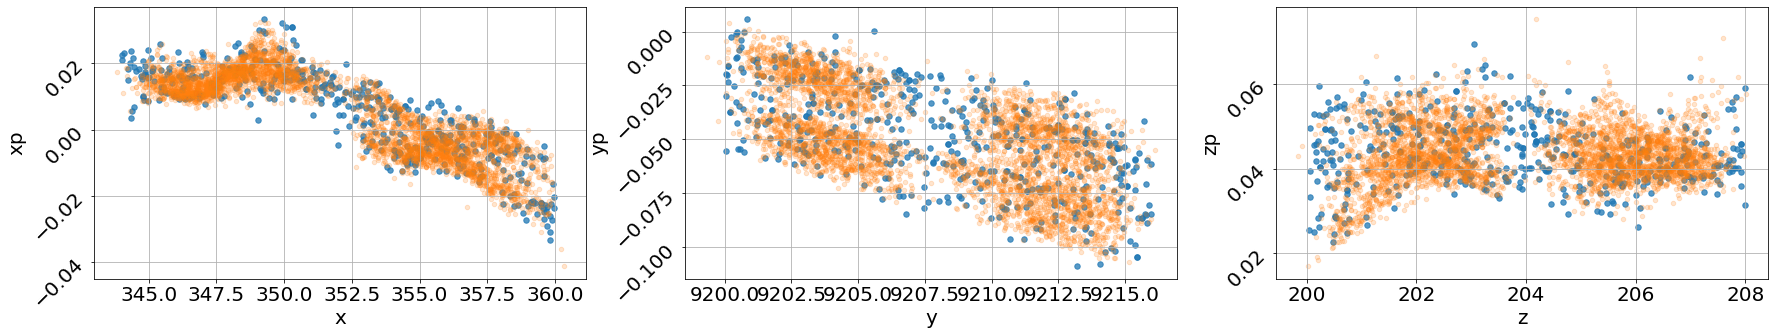

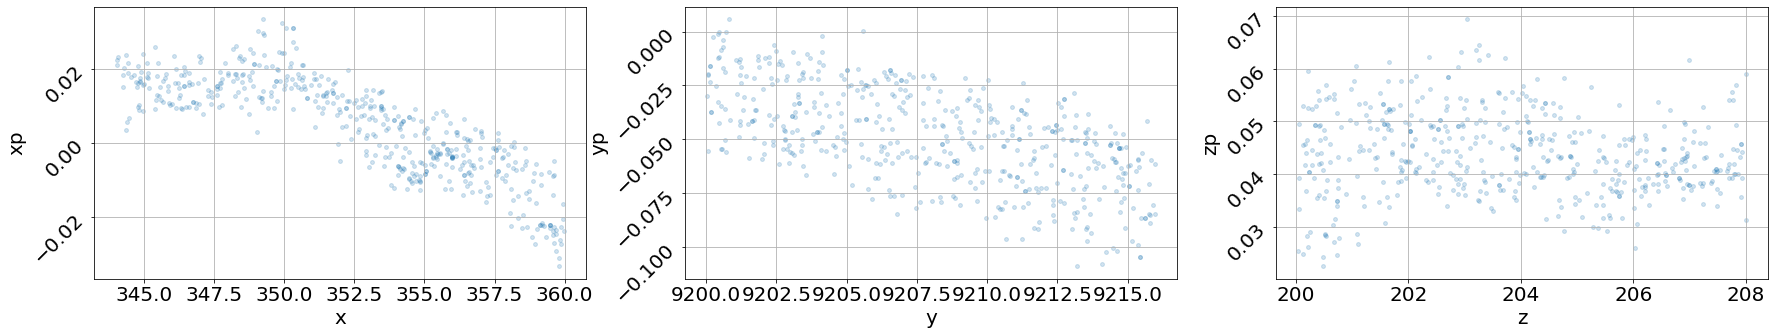

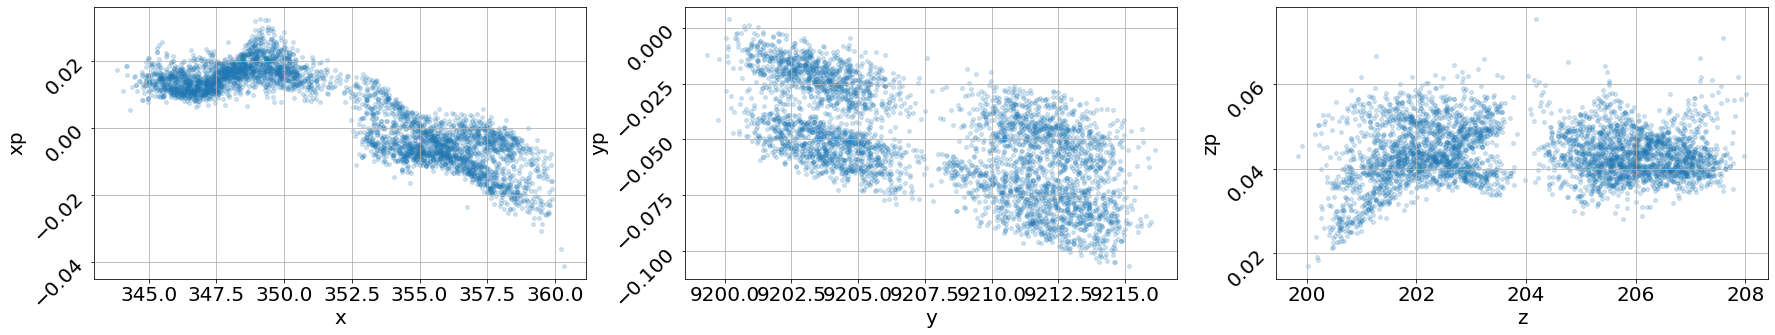

In [24]:
def plot_2D_GTandRec(pc, pc_pred, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=30, alpha=0.75)
    if pc_pred is not None:
        axs.scatter(pc_pred[:,comp_x], pc_pred[:,comp_y], s=20, alpha=0.2)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)
    
def plot_2D(pc, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=15, alpha=0.2)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))

for i in range(3):
    plot_2D_GTandRec(pointcloud_tensor, pred_pointcloud,
                     comp_x=i, comp_y=i+3, axs=axs[i],
                     label_x=labels_x[i], label_y=labels_y[i])
   

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_2D(pointcloud_tensor, comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_2D(pred_pointcloud, comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])

In [26]:
def plot_per_slice(pc, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        #std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]
        axs.plot([slice_ for slice_ in slices], mean_energy)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

def plot_per_slice_GTandRec(pc, pc_pred, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if pc_pred is not None:
        slices_pred = [np.min(pc_pred[:, slice_along]) + (np.max(pc_pred[:, slice_along]) - np.min(pc_pred[:, slice_along])) * i/num_slices for i in range(num_slices)]
        pc_pred_ = np.concatenate((pc_pred, np.zeros((pc_pred.shape[0], 1))), axis=1)

        for ind in range(len(slices_pred)-1):
            pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[ind]) & (pc_pred_[:, -3]<=slices_pred[ind+1])] = ind
        pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[-1])] = len(slices_pred) - 1
    
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]

        #axs.plot([slice_ for slice_ in slices], mean_energy, label="Groundtruth")
        if pc_pred is not None:
            print('plot pred', slices_pred)
            mean_energy_pred = [np.mean(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if (pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices_pred))]
            std_energy_pred = [np.std(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices_pred)) ]
            axs.plot([slice_ for slice_ in slices_pred], mean_energy_pred, label="Reconstruction")
            
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        axs.legend(prop={'size': 20})


    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        if pc_pred is not None:
            num_particles_pred = [pc_pred_[pc_pred_[:,-1]==ind].shape[0] for ind in range(len(slices_pred))]
            axs.plot([slice_ for slice_ in slices_pred], num_particles_pred)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

plot pred [202.56365966796875, 202.63222579956056, 202.70079193115234, 202.76935806274415, 202.83792419433593, 202.90649032592773, 202.97505645751954, 203.04362258911132, 203.11218872070313, 203.1807548522949, 203.24932098388672, 203.31788711547853, 203.3864532470703, 203.45501937866212, 203.5235855102539, 203.5921516418457, 203.6607177734375, 203.7292839050293, 203.7978500366211, 203.86641616821288, 203.9349822998047, 204.0035484313965, 204.07211456298828, 204.14068069458008, 204.20924682617186, 204.27781295776367, 204.34637908935548, 204.41494522094726, 204.48351135253907, 204.55207748413085, 204.62064361572266, 204.68920974731446, 204.75777587890624, 204.82634201049805, 204.89490814208983, 204.96347427368164, 205.03204040527345, 205.10060653686523, 205.16917266845704, 205.23773880004882, 205.30630493164062, 205.37487106323243, 205.4434371948242, 205.51200332641602, 205.5805694580078, 205.6491355895996, 205.71770172119142, 205.7862678527832, 205.854833984375, 205.92340011596679, 205.

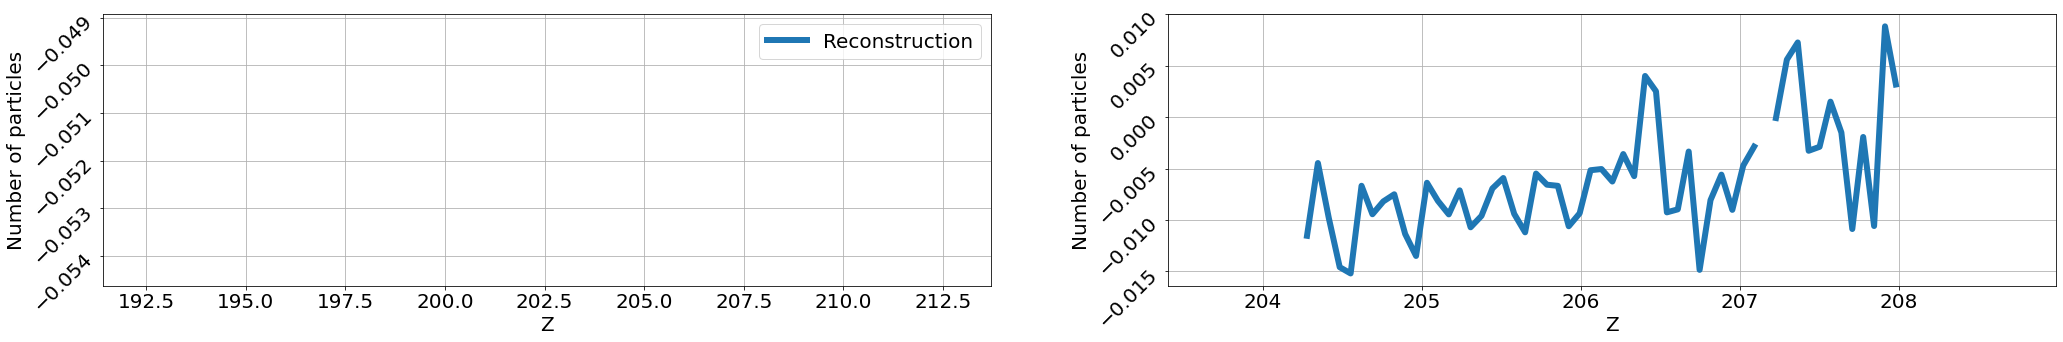

In [27]:
slice_along = 2 #z: 2
num_slices = 100
comp_of_interest = -3
figsize1 = 35
figsize2 = 5

fig, axs = plt.subplots(1, 2, figsize=(figsize1,figsize2))
plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
                        slice_along, num_slices, comp_of_interest,
                        axs[0], label='Number of particles')

plot_per_slice(pred_pointcloud, slice_along, num_slices, comp_of_interest, axs[1], label='Number of particles')

#for i in range(1,4,1):
#    visualizations.plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
#                        slice_along, num_slices, comp_of_interest=-1*i,
#                        axs=axs[i], label='Mean ' + labels_y[-1*i])